<a href="https://colab.research.google.com/github/PY09052021/DeepLearningSpring2022/blob/main/TIC_TAC_TOE_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# loading the dependencies
import random
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.backend import reshape
from keras.utils.np_utils import to_categorical

In [5]:
# Get an empty board
#
# 0 indicates an empty space, 1 indicates an 'X' (player 1), and 2 indicates an 'O' (player 2)
#
# Initially the board is empty, so we return a 3x3 array of zeroes.
def initBoard():
    board = [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    return board

# Print the current state of the board
def printBoard(board):
    for i in range(len(board)):
        for j in range(len(board[i])):
            mark = ' '
            if board[i][j] == 1:
                mark = 'X'
            elif board[i][j] == 2:
                mark = 'O'
            if (j == len(board[i]) - 1):
                print(mark)
            else:
                print(str(mark) + "|", end='')
        if (i < len(board) - 1):
            print("-----")

# Get a list of valid moves (indices into the board)
def getMoves(board):
    moves = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                moves.append((i, j))
    return moves

# Declare a winner
#
# -1 = game not over
#  0 = draw
#  1 = 'X' wins (player 1)
#  2 = 'O' wins (player 2)
def getWinner(board):
    candidate = 0
    won = 0
    
    # Check rows
    for i in range(len(board)):
        candidate = 0
        for j in range(len(board[i])):
            
            # Make sure there are no gaps
            if board[i][j] == 0:
                break
            
            # Identify the front-runner
            if candidate == 0:
                candidate = board[i][j]
            
            # Determine whether the front-runner has all the slots
            if candidate != board[i][j]:
                break
            elif j == len(board[i]) - 1:
                won = candidate
    
    if won > 0:
        return won
    
    # Check columns
    for j in range(len(board[0])):
        candidate = 0
        for i in range(len(board)):
            
            # Make sure there are no gaps
            if board[i][j] == 0:
                break
            
            # Identify the front-runner
            if candidate == 0:
                candidate = board[i][j]
            
            # Determine whether the front-runner has all the slots
            if candidate != board[i][j]:
                break
            elif i == len(board) - 1:
                won = candidate
    
    if won > 0:
        return won
    
    # Check diagonals
    candidate = 0
    for i in range(len(board)):
        if board[i][i] == 0:
            break
        if candidate == 0:
            candidate = board[i][i]
        if candidate != board[i][i]:
            break
        elif i == len(board) - 1:
            won = candidate
    
    if won > 0:
        return won
    
    candidate = 0
    for i in range(len(board)):
        if board[2 - i][2 - i] == 0:
            break
        if candidate == 0:
            candidate = board[2 - i][2 - i]
        if candidate != board[2 - i][2 - i]:
            break
        elif i == len(board) - 1:
            won = candidate
    
    if won > 0:
        return won
    
    # Still no winner?
    if (len(getMoves(board)) == 0):
        # It's a draw
        return 0
    else:
        # Still more moves to make
        return -1

In [6]:
#we test the helper methods to demonstrate that they work.
b = initBoard()
printBoard(b)
print(getWinner(b))
print(getMoves(b))

b[0][0] = 1
b[1][1] = 1
b[2][2] = 1
printBoard(b)
print(getWinner(b))

b[0][2] = 2
b[1][2] = 2
b[2][2] = 2
printBoard(b)
print(getWinner(b))

b[0][1] = 1
b[1][0] = 2
b[2][0] = 1
b[2][1] = 2
b[2][2] = 1
b[0][0] = 2
printBoard(b)
print(getWinner(b))


 | | 
-----
 | | 
-----
 | | 
-1
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
X| | 
-----
 |X| 
-----
 | |X
1
X| |O
-----
 |X|O
-----
 | |O
2
O|X|O
-----
O|X|O
-----
X|O|X
0


In [7]:
random.seed()

# Get best next move for the given player at the given board position
def bestMove(board, model, player, rnd=0):
    scores = []
    moves = getMoves(board)
    
    # Make predictions for each possible move
    for i in range(len(moves)):
        future = np.array(board)
        future[moves[i][0]][moves[i][1]] = player
        prediction = model.predict(future.reshape((-1, 9)))[0]
        if player == 1:
            winPrediction = prediction[1]
            lossPrediction = prediction[2]
        else:
            winPrediction = prediction[2]
            lossPrediction = prediction[1]
        drawPrediction = prediction[0]
        if winPrediction - lossPrediction > 0:
            scores.append(winPrediction - lossPrediction)
        else:
            scores.append(drawPrediction - lossPrediction)

    # Choose the best move with a random factor
    bestMoves = np.flip(np.argsort(scores))
    for i in range(len(bestMoves)):
        if random.random() * rnd < 0.5:
            return moves[bestMoves[i]]

    # Choose a move completely at random
    return moves[random.randint(0, len(moves) - 1)]

# Simulate a game
def simulateGame(p1=None, p2=None, rnd=0):
    history = []
    board = initBoard()
    playerToMove = 1
    
    while getWinner(board) == -1:
        
        # Chose a move (random or use a player model if provided)
        move = None
        if playerToMove == 1 and p1 != None:
            move = bestMove(board, p1, playerToMove, rnd)
        elif playerToMove == 2 and p2 != None:
            move = bestMove(board, p2, playerToMove, rnd)
        else:
            moves = getMoves(board)
            move = moves[random.randint(0, len(moves) - 1)]
        
        # Make the move
        board[move[0]][move[1]] = playerToMove
        
        # Add the move to the history
        history.append((playerToMove, move))
        
        # Switch the active player
        playerToMove = 1 if playerToMove == 2 else 2
        
    return history

# Simulate a game
history = simulateGame()
print(history)

[(1, (0, 1)), (2, (2, 0)), (1, (0, 0)), (2, (1, 2)), (1, (0, 2))]


In [8]:
# Reconstruct the board from the move list
def movesToBoard(moves):
    board = initBoard()
    for move in moves:
        player = move[0]
        coords = move[1]
        board[coords[0]][coords[1]] = player
    return board

board = movesToBoard(history)
printBoard(board)
print(getWinner(board))

X|X|X
-----
 | |O
-----
O| | 
1


In [9]:
games = [simulateGame() for _ in range(10000)]

In [10]:
# Aggregate win/loss/draw stats for a player
def gameStats(games, player=1):
    stats = {"win": 0, "loss": 0, "draw": 0}
    for game in games:
        result = getWinner(movesToBoard(game))
        if result == -1:
            continue
        elif result == player:
            stats["win"] += 1
        elif result == 0:
            stats["draw"] += 1
        else:
            stats["loss"] += 1
    
    winPct = stats["win"] / len(games) * 100
    lossPct = stats["loss"] / len(games) * 100
    drawPct = stats["draw"] / len(games) * 100

    print("Results for player %d:" % (player))
    print("Wins: %d (%.1f%%)" % (stats["win"], winPct))
    print("Loss: %d (%.1f%%)" % (stats["loss"], lossPct))
    print("Draw: %d (%.1f%%)" % (stats["draw"], drawPct))

gameStats(games)
print()
gameStats(games, player=2)

Results for player 1:
Wins: 5297 (53.0%)
Loss: 2368 (23.7%)
Draw: 2335 (23.4%)

Results for player 2:
Wins: 2368 (23.7%)
Loss: 5297 (53.0%)
Draw: 2335 (23.4%)


In [11]:
#DNN architecture
# flat array of 9 elements, each element of which can be a 0 (empty cell), 1 (player 1 move), or 2 (player 2 move)
# a one-hot encoded array

def getModel():
    numCells = 9 # How many cells in a 3x3 tic-tac-toe board?
    outcomes = 3 # How many outcomes are there in a game? (draw, X-wins, O-wins)
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape=(9, )))
    model.add(Dropout(0.2))
    model.add(Dense(125, activation='relu'))
    model.add(Dense(75, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(outcomes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    return model
model = getModel()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               2000      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 125)               25125     
                                                                 
 dense_8 (Dense)             (None, 75)                9450      
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 dense_9 (Dense)             (None, 25)                1900      
                                                                 
 dense_10 (Dense)            (None, 3)                

In [12]:
# baseline model with 3 layers
import keras.models as Km
import keras.layers as Kl
def getModel2():
  model2 = Km.Sequential()
  model2.add(Kl.Dense(18, activation='relu', input_dim=9))
  model2.add(Kl.Dense(18, activation='relu'))
  model2.add(Kl.Dense(1, activation='linear'))
  model2.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
  return model2 
model2=getModel2()
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 18)                180       
                                                                 
 dense_12 (Dense)            (None, 18)                342       
                                                                 
 dense_13 (Dense)            (None, 1)                 19        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# Get a set of board states labelled by who eventually won that game
def gamesToWinLossData(games):
    X = []
    y = []
    for game in games:
        winner = getWinner(movesToBoard(game))
        for move in range(len(game)):
            X.append(movesToBoard(game[:(move + 1)]))
            y.append(winner)

    X = np.array(X).reshape((-1, 9))
    y = to_categorical(y)
    
    # Return an appropriate train/test split
    trainNum = int(len(X) * 0.8)
    return (X[:trainNum], X[trainNum:], y[:trainNum], y[trainNum:])

# Split out train and validation data
X_train, X_test, y_train, y_test = gamesToWinLossData(games)

Epoch 1/25
625/625 [==============================] - 3s 4ms/step - loss: 1.0080 - acc: 0.5212 - val_loss: 0.9623 - val_acc: 0.5674
Epoch 2/25
625/625 [==============================] - 2s 3ms/step - loss: 0.9489 - acc: 0.5570 - val_loss: 0.9068 - val_acc: 0.5852
Epoch 3/25
625/625 [==============================] - 2s 4ms/step - loss: 0.9081 - acc: 0.5718 - val_loss: 0.8732 - val_acc: 0.5920
Epoch 4/25
625/625 [==============================] - 2s 3ms/step - loss: 0.8826 - acc: 0.5820 - val_loss: 0.8543 - val_acc: 0.6068
Epoch 5/25
625/625 [==============================] - 2s 3ms/step - loss: 0.8649 - acc: 0.5936 - val_loss: 0.8408 - val_acc: 0.6097
Epoch 6/25
625/625 [==============================] - 2s 3ms/step - loss: 0.8517 - acc: 0.6011 - val_loss: 0.8301 - val_acc: 0.6234
Epoch 7/25
625/625 [==============================] - 2s 3ms/step - loss: 0.8392 - acc: 0.6087 - val_loss: 0.8153 - val_acc: 0.6279
Epoch 8/25
625/625 [==============================] - 2s 3ms/step - loss: 0.

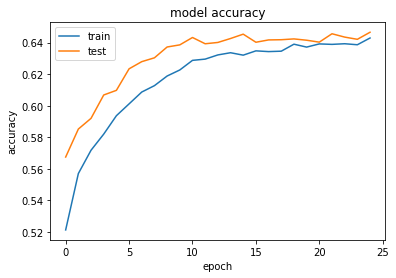

In [14]:
import matplotlib.pyplot as plt


nEpochs = 25
batchSize = 100
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nEpochs, batch_size=batchSize)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Simulating baseline model with similar data**

Epoch 1/25
625/625 [==============================] - 2s 2ms/step - loss: 0.3665 - accuracy: 0.6541 - val_loss: 0.3381 - val_accuracy: 0.6667
Epoch 2/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3364 - accuracy: 0.6667 - val_loss: 0.3354 - val_accuracy: 0.6667
Epoch 3/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3351 - accuracy: 0.6667 - val_loss: 0.3345 - val_accuracy: 0.6667
Epoch 4/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3349 - accuracy: 0.6667 - val_loss: 0.3353 - val_accuracy: 0.6667
Epoch 5/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3345 - accuracy: 0.6667 - val_loss: 0.3349 - val_accuracy: 0.6667
Epoch 6/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.6667 - val_loss: 0.3355 - val_accuracy: 0.6667
Epoch 7/25
625/625 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.6667 - val_loss: 0.3337 - val_accuracy: 0.6667
Epoch 

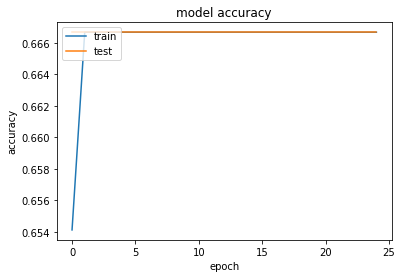

In [15]:
# Simulating baseline model with similar data
nEpochs = 25
batchSize = 100
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nEpochs, batch_size=batchSize)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [16]:
games2 = [simulateGame(p1=model) for _ in range(1000)]
gameStats(games2)

Results for player 1:
Wins: 907 (90.7%)
Loss: 26 (2.6%)
Draw: 67 (6.7%)


In [17]:
games4 = [simulateGame(p1=model, p2=model, rnd=0.6) for _ in range(250)]
gameStats(games4, player=1)
print()
gameStats(games4, player=2)

Results for player 1:
Wins: 72 (28.8%)
Loss: 29 (11.6%)
Draw: 149 (59.6%)

Results for player 2:
Wins: 29 (11.6%)
Loss: 72 (28.8%)
Draw: 149 (59.6%)


In [18]:
games3 = [simulateGame(p2=model) for _ in range(100)]
gameStats(games3, player=2)

Results for player 2:
Wins: 27 (27.0%)
Loss: 7 (7.0%)
Draw: 66 (66.0%)


In [19]:
print("Average length of fully random game is %f moves" % (np.mean([float(len(game)) for game in games])))
print("Average length of game where P1 uses NN is %f moves" % (np.mean([float(len(game)) for game in games2])))
print("Average length of game where P2 uses NN is %f moves" % (np.mean([float(len(game)) for game in games3])))
print("Average length of game where both use NN is %f moves" % (np.mean([float(len(game)) for game in games4])))

Average length of fully random game is 7.806000 moves
Average length of game where P1 uses NN is 7.058000 moves
Average length of game where P2 uses NN is 8.070000 moves
Average length of game where both use NN is 8.180000 moves


In [20]:
# Create new board
board = initBoard()

# Move 1 (computer)
move = bestMove(board, model, 1)
board[move[0]][move[1]] = 1
printBoard(board)

 | | 
-----
 |X| 
-----
 | | 


In [21]:
# Tic Tac Toe Champion(human name : Tee Teidol)
board[1][1] = 2
printBoard(board)

 | | 
-----
 |O| 
-----
 | | 


In [22]:
move = bestMove(board, model, 1)
board[move[0]][move[1]] = 1
printBoard(board)

 | | 
-----
 |O| 
-----
 | |X


In [23]:
board[2][0] = 2
printBoard(board)

 | | 
-----
 |O| 
-----
O| |X


In [24]:
move = bestMove(board, model, 1)
board[move[0]][move[1]] = 1
printBoard(board)

 | | 
-----
 |O|X
-----
O| |X


In [25]:
board[0][1] = 2
printBoard(board)

 |O| 
-----
 |O|X
-----
O| |X


In [26]:
move = bestMove(board, model, 1)
board[move[0]][move[1]] = 1
printBoard(board)

 |O|X
-----
 |O|X
-----
O| |X


In [27]:
getWinner(board)

1